**MVP: Machine Learning & Analytics**

Nome: Daniela de Sousa Arrais

Matrícula: 4052025001347

Dataset: Base de Apólices de Seguros e Base de Sinistros

**Análise de Rentabilidade e Previsão de Esforço Operacional**

Implementação de um sistema de ML para:
1. Prever esforço operacional de novas apólices
2. Classificar apólices como "trabalhosas" ou "normais"
3. Identificar fatores que impactam a eficiência operacional
4. Auxiliar na negociação de comissões com seguradoras

O objetivo é construir modelos que ajudem a corretora a:
- Prever antecipadamente quais apólices demandarão mais esforço
- Identificar padrões de ineficiência por seguradora
- Justificar pedidos de aumento de comissão com dados quantitativos

**SETUP E CONFIGURAÇÕES**


In [1]:
import os, random, time, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score,
                             classification_report, ConfusionMatrixDisplay)

from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV
from scipy.stats import randint, uniform
import joblib
import json

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print(f"Python: {sys.version.split()[0]}")
print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Seed global: {SEED}")

Python: 3.12.11
Pandas: 2.2.2
Numpy: 2.0.2
Seed global: 42


**FUNÇÕES AUXILIARES**

In [2]:
"""Avalia modelo de classificação com métricas completas"""
def evaluate_classification(y_true, y_pred, proba=None):
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted")
    f1_macro = f1_score(y_true, y_pred, average="macro")

    if proba is not None and len(np.unique(y_true)) == 2:
        auc = roc_auc_score(y_true, proba[:, 1])
    else:
        auc = np.nan

    return {
        "accuracy": round(acc, 4),
        "f1_weighted": round(f1w, 4),
        "f1_macro": round(f1_macro, 4),
        "roc_auc": round(auc, 4) if not np.isnan(auc) else None
    }

In [3]:
"""Avalia modelo de regressão com métricas de negócio"""
def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Métrica de negócio: % de previsões dentro de ±20%
    tolerance = 0.20
    within_tolerance = np.mean(np.abs(y_pred - y_true) / np.abs(y_true) <= tolerance)

    return {
        "MAE": round(mae, 3),
        "RMSE": round(rmse, 3),
        "R2": round(r2, 4),
        "Within_20pct": round(within_tolerance, 4)
    }

In [4]:
"""Calcula IRO detalhado por seguradora"""
def calcular_iro_detalhado(df):
    iro_data = df.groupby('seguradora').agg({
        'comissao_pct': 'mean',
        'comissao_valor': 'mean',
        'esforco_operacional': 'mean',
        'valor_premio': ['mean', 'sum', 'count'],
        'num_contatos': 'mean',
        'dias_ate_emissao': 'mean',
        'num_retrabalhos': 'mean',
        'is_trabalhosa': 'mean'
    }).round(3)

    # Flatten colunas
    iro_data.columns = ['comissao_pct_media', 'comissao_valor_media', 'esforco_medio',
                       'premio_medio', 'volume_total', 'num_apolices',
                       'contatos_medio', 'dias_medio', 'retrabalhos_medio', 'pct_trabalhosas']

    # Calcular IRO
    iro_data['IRO'] = (iro_data['comissao_valor_media'] / iro_data['esforco_medio']).round(2)

    # Receita total de comissões
    iro_data['receita_total_comissoes'] = (iro_data['volume_total'] * iro_data['comissao_pct_media'] / 100).round(2)

    # Classificação de status
    def classify_status(row):
        iro = row['IRO']
        if iro >= 40:
            return 'Excelente'
        elif iro >= 25:
            return 'Muito Bom'
        elif iro >= 18:
            return 'Bom'
        elif iro >= 12:
            return 'Regular'
        else:
            return 'Crítico'

    iro_data['status_iro'] = iro_data.apply(classify_status, axis=1)

    # Sugestão de aumento
    def suggest_increase(row):
        iro = row['IRO']
        if iro < 15:
            return 3.5
        elif iro < 20:
            return 2.5
        elif iro < 25:
            return 1.5
        else:
            return 0.0

    iro_data['aumento_sugerido'] = iro_data.apply(suggest_increase, axis=1)

    # Potencial financeiro
    iro_data['potencial_ganho_anual'] = (iro_data['volume_total'] * iro_data['aumento_sugerido'] / 100).round(2)

    return iro_data.sort_values('IRO', ascending=False)

**CARREGAMENTO DOS DADOS**

In [5]:
import gdown
import pandas as pd
import os

def download_files():
    """Baixa os arquivos do Google Drive"""

    # URLs dos arquivos compartilhados
    url1 = "https://drive.google.com/file/d/1mBNlIrh7odCT2SVfO-gUJzXC-Zrz9uhL/view?usp=drive_link"
    url2 = "https://drive.google.com/file/d/13CQ_GAyPh_b_MFT8TpUfwo2N8xNRN3Hb/view?usp=drive_link"

    # Nomes dos arquivos de saída
    output1 = "base_apolices_completa.csv"
    output2 = "base_sinistros.csv"

    try:
        gdown.download(url1, output1, quiet=True, fuzzy=True)
        gdown.download(url2, output2, quiet=True, fuzzy=True)
        return True
    except Exception as e:
        print(f"Erro no download: {e}")
        return False

def load_csv_data():
    """Carrega os dados dos CSVs"""

    required_files = ['base_apolices_completa.csv', 'base_sinistros.csv']

    # Verificar se arquivos existem
    missing_files = [f for f in required_files if not os.path.exists(f)]

    if missing_files:
        if not download_files():
            return None, None

    # Carregar dados
    try:
        df_apolices = pd.read_csv('base_apolices_completa.csv')
        df_sinistros = pd.read_csv('base_sinistros.csv')
        return df_apolices, df_sinistros

    except Exception as e:
        print(f"Erro ao carregar arquivos: {e}")
        return None, None




In [6]:
# Executar carregamento
df_apolices, df_sinistros = load_csv_data()

if df_apolices is None:
    print("Não foi possível carregar os dados. Verifique se os arquivos CSV estão no diretório.")
else:
    print(f"Dados prontos para análise!")

Dados prontos para análise!


In [7]:
print(f"• Apólices: {df_apolices.shape[0]} linhas x {df_apolices.shape[1]} colunas")
print(f"• Sinistros: {df_sinistros.shape[0]} linhas x {df_sinistros.shape[1]} colunas")

print(f"\n AMOSTRA DOS DADOS:")
display(df_apolices.head())

print(f"\n TIPOS DE DADOS:")
print(df_apolices.dtypes)

print(f"\n VALORES AUSENTES:")
missing_data = df_apolices.isnull().sum()
if missing_data.sum() > 0:
    print("Dados faltantes por coluna:")
    for col, missing in missing_data[missing_data > 0].items():
        pct = (missing / len(df_apolices)) * 100
        print(f"   • {col}: {missing} ({pct:.1f}%)")
else:
    print(" Nenhum valor ausente encontrado!")

• Apólices: 100 linhas x 16 colunas
• Sinistros: 100 linhas x 18 colunas

 AMOSTRA DOS DADOS:


,numero_apolice,tipo_seguro,seguradora,valor_premio,comissao_pct,comissao_valor,data_inicio,data_fim,corretor_responsavel,num_contatos,dias_ate_emissao,num_retrabalhos,horas_gastas_equipe,num_sinistros,esforco_operacional,is_trabalhosa
0,AP2023000001,Auto,Porto Seguro,2847.35,12.5,355.92,2023-03-15,2024-03-15,João Silva,8,12,1.0,7.2,0,15.5,1
1,AP2023000002,Saude,Bradesco Seguros,5234.12,9.8,512.74,2023-01-08,2024-01-08,Maria Santos,12,18,2.0,11.5,1,26.0,1
2,AP2023000003,Empresarial,Sulamérica,9832.45,13.8,1356.88,2023-02-22,2024-02-22,Carlos Oliveira,4,6,NaN,4.1,0,11.0,0
3,AP2023000004,Auto,Azul Seguros,3124.67,7.2,224.98,2023-04-12,2024-04-12,Ana Costa,15,25,3.0,14.8,2,30.0,1
4,AP2023000005,Vida,Mapfre,1543.21,10.8,166.67,2023-01-30,2024-01-30,Pedro Lima,6,8,0.0,5.3,0,14.0,0



 TIPOS DE DADOS:
numero_apolice           object
tipo_seguro              object
seguradora               object
valor_premio            float64
comissao_pct            float64
comissao_valor          float64
data_inicio              object
data_fim                 object
corretor_responsavel     object
num_contatos              int64
dias_ate_emissao          int64
num_retrabalhos         float64
horas_gastas_equipe     float64
num_sinistros             int64
esforco_operacional     float64
is_trabalhosa             int64
dtype: object

 VALORES AUSENTES:
Dados faltantes por coluna:
   • num_retrabalhos: 1 (1.0%)


**ANÁLISE EXPLORATÓRIA**





 ESTATÍSTICAS PRINCIPAIS:
• Seguradoras: 8
• Tipos de seguro: 6
• Esforço médio: 18.0 pontos
• Taxa apólices trabalhosas: 57.0%
• Valor médio prêmio: R$ 3,914.20


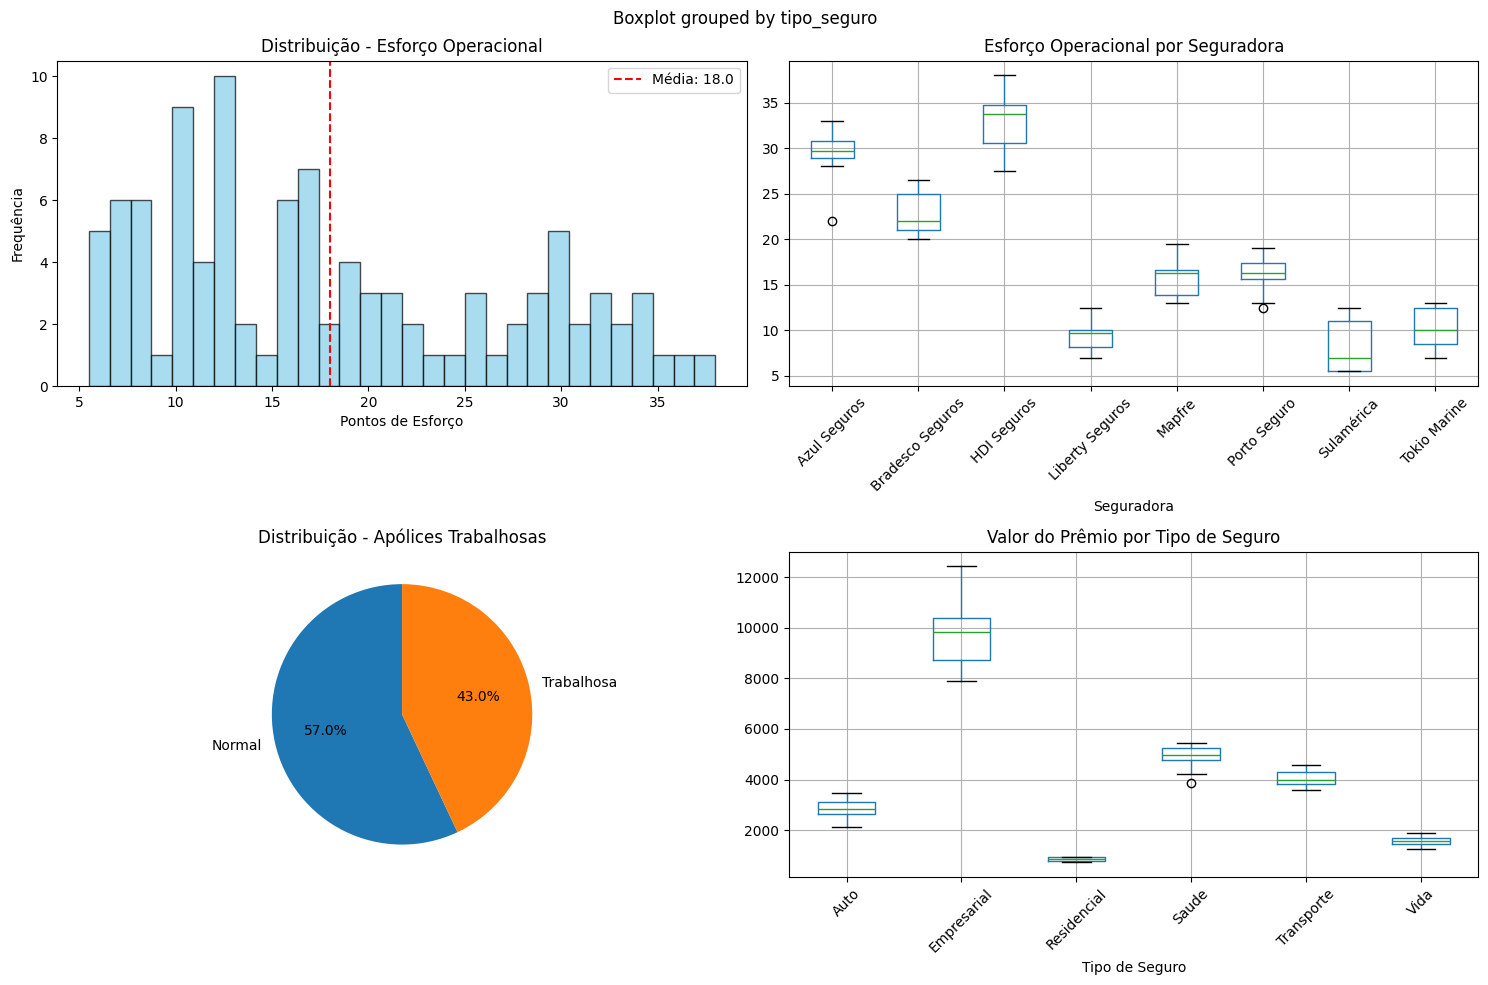


 CORRELAÇÕES COM ESFORÇO OPERACIONAL:
esforco_operacional    1.000000
num_contatos           0.992961
dias_ate_emissao       0.990128
num_retrabalhos        0.972379
valor_premio           0.040181
Name: esforco_operacional, dtype: float64


In [8]:
# Estatísticas descritivas
print(f"\n ESTATÍSTICAS PRINCIPAIS:")
print(f"• Seguradoras: {df_apolices['seguradora'].nunique()}")
print(f"• Tipos de seguro: {df_apolices['tipo_seguro'].nunique()}")
print(f"• Esforço médio: {df_apolices['esforco_operacional'].mean():.1f} pontos")
print(f"• Taxa apólices trabalhosas: {df_apolices['is_trabalhosa'].mean()*100:.1f}%")
print(f"• Valor médio prêmio: R$ {df_apolices['valor_premio'].mean():,.2f}")

# Visualizações principais
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Análise Exploratória - Principais Insights', fontsize=16, fontweight='bold')

# 1. Distribuição do esforço operacional
axes[0,0].hist(df_apolices['esforco_operacional'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribuição - Esforço Operacional')
axes[0,0].set_xlabel('Pontos de Esforço')
axes[0,0].set_ylabel('Frequência')
axes[0,0].axvline(df_apolices['esforco_operacional'].mean(), color='red', linestyle='--',
                  label=f'Média: {df_apolices["esforco_operacional"].mean():.1f}')
axes[0,0].legend()

# 2. Esforço por seguradora
df_apolices.boxplot(column='esforco_operacional', by='seguradora', ax=axes[0,1])
axes[0,1].set_title('Esforço Operacional por Seguradora')
axes[0,1].set_xlabel('Seguradora')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Distribuição de apólices trabalhosas
trabalhosa_counts = df_apolices['is_trabalhosa'].value_counts()
axes[1,0].pie(trabalhosa_counts.values, labels=['Normal', 'Trabalhosa'], autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Distribuição - Apólices Trabalhosas')

# 4. Valor do prêmio por tipo de seguro
df_apolices.boxplot(column='valor_premio', by='tipo_seguro', ax=axes[1,1])
axes[1,1].set_title('Valor do Prêmio por Tipo de Seguro')
axes[1,1].set_xlabel('Tipo de Seguro')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Correlações importantes
print(f"\n CORRELAÇÕES COM ESFORÇO OPERACIONAL:")
numeric_cols = ['valor_premio', 'comissao_pct', 'num_contatos', 'dias_ate_emissao', 'num_retrabalhos']
available_numeric = [col for col in numeric_cols if col in df_apolices.columns]
if available_numeric:
    correlations = df_apolices[available_numeric + ['esforco_operacional']].corr()['esforco_operacional'].sort_values(ascending=False)
    print(correlations[:-1])  # Excluir auto-correlação


**DEFINIÇÃO DO TARGET, VARIÁVEIS E DIVISÃO DOS DADOS**

In [9]:
# Definir problemas de ML
PROBLEMS = {
    'regressao': {
        'target': 'esforco_operacional',
        'description': 'Prever esforço operacional (pontos) de novas apólices',
        'type': 'regressao'
    },
    'classificacao': {
        'target': 'is_trabalhosa',
        'description': 'Classificar apólices como trabalhosas (1) ou normais (0)',
        'type': 'classificacao'
    }
}

print(f"PROBLEMAS DE ML DEFINIDOS:")
for name, info in PROBLEMS.items():
    print(f"• {name.upper()}: {info['description']}")

# Features disponíveis (excluir targets e variáveis derivadas)
available_features = ['seguradora', 'tipo_seguro', 'corretor_responsavel', 'valor_premio',
                     'comissao_pct', 'num_contatos', 'dias_ate_emissao', 'num_retrabalhos',
                     'num_sinistros']

# Verificar quais features existem nos dados
existing_features = [f for f in available_features if f in df_apolices.columns]
missing_features = [f for f in available_features if f not in df_apolices.columns]

print(f"\n FEATURES:")
print(f"• Disponíveis: {len(existing_features)} - {existing_features}")
if missing_features:
    print(f"• Faltantes: {missing_features}")

# Validar targets
required_targets = ['esforco_operacional', 'is_trabalhosa']
missing_targets = [t for t in required_targets if t not in df_apolices.columns]

if missing_targets:
    print(f"Targets faltantes: {missing_targets}")
    sys.exit(1)

print(f"Targets validados: {required_targets}")


PROBLEMAS DE ML DEFINIDOS:
• REGRESSAO: Prever esforço operacional (pontos) de novas apólices
• CLASSIFICACAO: Classificar apólices como trabalhosas (1) ou normais (0)

 FEATURES:
• Disponíveis: 9 - ['seguradora', 'tipo_seguro', 'corretor_responsavel', 'valor_premio', 'comissao_pct', 'num_contatos', 'dias_ate_emissao', 'num_retrabalhos', 'num_sinistros']
Targets validados: ['esforco_operacional', 'is_trabalhosa']


**TRATAMENTO DE DADOS E PIPELINE DE PRÉ-PROCESSAMENTO**


In [10]:
# Limpar dados faltantes
df_clean = df_apolices.copy()

print(" TRATAMENTO DE DADOS FALTANTES:")

# Tratar valores faltantes por seguradora (estratégia inteligente)
for col in ['num_contatos', 'dias_ate_emissao', 'num_retrabalhos', 'horas_gastas_equipe']:
    if col in df_clean.columns:
        missing_count = df_clean[col].isnull().sum()
        if missing_count > 0:
            # Imputação por seguradora (mediana)
            df_clean[col] = df_clean.groupby('seguradora')[col].transform(
                lambda x: x.fillna(x.median())
            )
            print(f"   • {col}: {missing_count} valores imputados por mediana da seguradora")

# Tratar comissão faltante
if 'comissao_pct' in df_clean.columns and df_clean['comissao_pct'].isnull().sum() > 0:
    missing_count = df_clean['comissao_pct'].isnull().sum()
    df_clean['comissao_pct'] = df_clean.groupby('seguradora')['comissao_pct'].transform(
        lambda x: x.fillna(x.mean())
    )
    print(f"   • comissao_pct: {missing_count} valores imputados por média da seguradora")

# Filtrar apenas features que existem
final_features = [f for f in existing_features if f in df_clean.columns]

print(f"\n FEATURES FINAIS: {len(final_features)}")
for i, feature in enumerate(final_features, 1):
    print(f"{i:2d}. {feature}")

# Separar features categóricas e numéricas
numeric_features = ['valor_premio', 'comissao_pct', 'num_contatos',
                   'dias_ate_emissao', 'num_retrabalhos', 'num_sinistros']
categorical_features = ['seguradora', 'tipo_seguro', 'corretor_responsavel']

# Filtrar apenas features que existem
numeric_features = [f for f in numeric_features if f in final_features]
categorical_features = [f for f in categorical_features if f in final_features]

print(f"\n TIPOS DE FEATURES:")
print(f"• Numéricas ({len(numeric_features)}): {numeric_features}")
print(f"• Categóricas ({len(categorical_features)}): {categorical_features}")

# Pipeline de pré-processamento
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pipeline completo
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

print(f"\n PIPELINE DE PRÉ-PROCESSAMENTO CRIADO:")
print(f"   • Numéricas: Imputação (mediana) + Padronização")
print(f"   • Categóricas: Imputação (moda) + One-Hot Encoding")
print(f"   • Evita vazamento de dados: ")


 TRATAMENTO DE DADOS FALTANTES:
   • num_retrabalhos: 1 valores imputados por mediana da seguradora

 FEATURES FINAIS: 9
 1. seguradora
 2. tipo_seguro
 3. corretor_responsavel
 4. valor_premio
 5. comissao_pct
 6. num_contatos
 7. dias_ate_emissao
 8. num_retrabalhos
 9. num_sinistros

 TIPOS DE FEATURES:
• Numéricas (6): ['valor_premio', 'comissao_pct', 'num_contatos', 'dias_ate_emissao', 'num_retrabalhos', 'num_sinistros']
• Categóricas (3): ['seguradora', 'tipo_seguro', 'corretor_responsavel']

 PIPELINE DE PRÉ-PROCESSAMENTO CRIADO:
   • Numéricas: Imputação (mediana) + Padronização
   • Categóricas: Imputação (moda) + One-Hot Encoding
   • Evita vazamento de dados: 


**MODELOS DE MACHINE LEARNING COM BASELINE**



In [11]:
# Preparar dados para modelagem
X = df_clean[available_features].copy()

**PROBLEMA 1: PREDIÇÃO DE ESFORÇO OPERACIONAL (REGRESSÃO)**

In [12]:
y_esforco = df_clean['esforco_operacional'].copy()

# Dividir dados
X_train_esf, X_test_esf, y_train_esf, y_test_esf = train_test_split(
    X, y_esforco, test_size=0.2, random_state=SEED
)

print(f"Dados divididos: {X_train_esf.shape[0]} treino | {X_test_esf.shape[0]} teste")

# BASELINE para regressão
baseline_regressao = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DummyRegressor(strategy='median'))
])

# CANDIDATOS para regressão
candidatos_regressao = {
    'Ridge': Pipeline([
        ('preprocessor', preprocessor),
        ('model', Ridge(random_state=SEED))
    ]),
    'Random_Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=100, random_state=SEED))
    ]),
    'Gradient_Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(random_state=SEED))
    ])
}

print(f"\nBASELINE: DummyRegressor (mediana)")
print(f"CANDIDATOS: {list(candidatos_regressao.keys())}")

# Treinar e avaliar BASELINE
print(f"\nAvaliando BASELINE (Regressão)...")
import time

results_regressao = {}

t0 = time.time()
baseline_regressao.fit(X_train_esf, y_train_esf)
t1 = time.time()
y_pred_baseline = baseline_regressao.predict(X_test_esf)
metrics_baseline = evaluate_regression(y_test_esf, y_pred_baseline)
metrics_baseline['train_time_s'] = round(t1 - t0, 3)
results_regressao['Baseline_Median'] = metrics_baseline

print(f"   Baseline - R²: {metrics_baseline['R2']:.3f} | MAE: {metrics_baseline['MAE']:.2f} | Tempo: {metrics_baseline['train_time_s']}s")

# Treinar e avaliar CANDIDATOS
for nome, modelo in candidatos_regressao.items():
    print(f"Treinando {nome}...")

    t0 = time.time()
    modelo.fit(X_train_esf, y_train_esf)
    t1 = time.time()
    y_pred = modelo.predict(X_test_esf)

    metrics = evaluate_regression(y_test_esf, y_pred)
    metrics['train_time_s'] = round(t1 - t0, 3)
    results_regressao[nome] = metrics

    print(f"   {nome} - R²: {metrics['R2']:.3f} | MAE: {metrics['MAE']:.2f} | Tempo: {metrics['train_time_s']}s")

# Exibir comparação
print(f"\nCOMPARAÇÃO REGRESSÃO - BASELINE vs CANDIDATOS:")
df_results_reg = pd.DataFrame(results_regressao).T
df_results_reg = df_results_reg.sort_values('R2', ascending=False)
print(df_results_reg)

# Selecionar melhor modelo de regressão
melhor_regressao = df_results_reg.index[0]
melhoria_r2 = ((df_results_reg.loc[melhor_regressao, 'R2'] - df_results_reg.loc['Baseline_Median', 'R2']) /
               abs(df_results_reg.loc['Baseline_Median', 'R2']) * 100)

print(f"\nMELHOR MODELO (Regressão): {melhor_regressao}")
print(f"   Melhoria sobre baseline: {melhoria_r2:+.1f}% em R²")

Dados divididos: 80 treino | 20 teste

BASELINE: DummyRegressor (mediana)
CANDIDATOS: ['Ridge', 'Random_Forest', 'Gradient_Boosting']

Avaliando BASELINE (Regressão)...
   Baseline - R²: -0.021 | MAE: 6.72 | Tempo: 0.021s
Treinando Ridge...
   Ridge - R²: 0.985 | MAE: 0.92 | Tempo: 0.034s
Treinando Random_Forest...
   Random_Forest - R²: 0.993 | MAE: 0.53 | Tempo: 0.326s
Treinando Gradient_Boosting...
   Gradient_Boosting - R²: 0.993 | MAE: 0.56 | Tempo: 0.214s

COMPARAÇÃO REGRESSÃO - BASELINE vs CANDIDATOS:
                     MAE   RMSE      R2  Within_20pct  train_time_s
Random_Forest      0.526  0.720  0.9933          1.00         0.326
Gradient_Boosting  0.562  0.722  0.9932          1.00         0.214
Ridge              0.916  1.061  0.9854          0.95         0.034
Baseline_Median    6.725  8.865 -0.0211          0.35         0.021

MELHOR MODELO (Regressão): Random_Forest
   Melhoria sobre baseline: +4807.6% em R²


**PROBLEMA 2: CLASSIFICAÇÃO DE APÓLICES TRABALHOSAS**

In [13]:
y_trabalhosa = df_clean['is_trabalhosa'].copy()

# Dividir dados com estratificação
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_trabalhosa, test_size=0.2, random_state=SEED, stratify=y_trabalhosa
)

print(f"Dados divididos: {X_train_clf.shape[0]} treino | {X_test_clf.shape[0]} teste")
print(f"Balanceamento mantido: {y_train_clf.value_counts().to_dict()}")

# BASELINE para classificação
baseline_classificacao = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DummyClassifier(strategy='most_frequent', random_state=SEED))
])

# CANDIDATOS para classificação
candidatos_classificacao = {
    'Logistic_Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter=1000, random_state=SEED))
    ]),
    'Random_Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(n_estimators=100, random_state=SEED))
    ]),
    'SVM': Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVC(probability=True, random_state=SEED))
    ])
}

print(f"\nBASELINE: DummyClassifier (classe mais frequente)")
print(f"CANDIDATOS: {list(candidatos_classificacao.keys())}")

# Treinar e avaliar BASELINE
print(f"\nAvaliando BASELINE (Classificação)...")

results_classificacao = {}

t0 = time.time()
baseline_classificacao.fit(X_train_clf, y_train_clf)
t1 = time.time()
y_pred_baseline_clf = baseline_classificacao.predict(X_test_clf)
y_proba_baseline_clf = baseline_classificacao.predict_proba(X_test_clf) if hasattr(baseline_classificacao, 'predict_proba') else None

metrics_baseline_clf = evaluate_classification(y_test_clf, y_pred_baseline_clf, y_proba_baseline_clf)
metrics_baseline_clf['train_time_s'] = round(t1 - t0, 3)
results_classificacao['Baseline_MostFrequent'] = metrics_baseline_clf

print(f"   Baseline - F1: {metrics_baseline_clf['f1_weighted']:.3f} | Acc: {metrics_baseline_clf['accuracy']:.3f} | Tempo: {metrics_baseline_clf['train_time_s']}s")

# Treinar e avaliar CANDIDATOS
for nome, modelo in candidatos_classificacao.items():
    print(f"Treinando {nome}...")

    t0 = time.time()
    modelo.fit(X_train_clf, y_train_clf)
    t1 = time.time()
    y_pred = modelo.predict(X_test_clf)
    y_proba = modelo.predict_proba(X_test_clf) if hasattr(modelo, 'predict_proba') else None

    metrics = evaluate_classification(y_test_clf, y_pred, y_proba)
    metrics['train_time_s'] = round(t1 - t0, 3)
    results_classificacao[nome] = metrics

    print(f"   {nome} - F1: {metrics['f1_weighted']:.3f} | Acc: {metrics['accuracy']:.3f} | Tempo: {metrics['train_time_s']}s")

# Exibir comparação
print(f"\nCOMPARAÇÃO CLASSIFICAÇÃO - BASELINE vs CANDIDATOS:")
df_results_clf = pd.DataFrame(results_classificacao).T
df_results_clf = df_results_clf.sort_values('f1_weighted', ascending=False)
print(df_results_clf)

# Selecionar melhor modelo de classificação
melhor_classificacao = df_results_clf.index[0]
melhoria_f1 = ((df_results_clf.loc[melhor_classificacao, 'f1_weighted'] - df_results_clf.loc['Baseline_MostFrequent', 'f1_weighted']) /
               df_results_clf.loc['Baseline_MostFrequent', 'f1_weighted'] * 100)

print(f"\nMELHOR MODELO (Classificação): {melhor_classificacao}")
print(f"   Melhoria sobre baseline: {melhoria_f1:+.1f}% em F1-weighted")


Dados divididos: 80 treino | 20 teste
Balanceamento mantido: {1: 46, 0: 34}

BASELINE: DummyClassifier (classe mais frequente)
CANDIDATOS: ['Logistic_Regression', 'Random_Forest', 'SVM']

Avaliando BASELINE (Classificação)...
   Baseline - F1: 0.390 | Acc: 0.550 | Tempo: 0.018s
Treinando Logistic_Regression...
   Logistic_Regression - F1: 0.950 | Acc: 0.950 | Tempo: 0.03s
Treinando Random_Forest...
   Random_Forest - F1: 1.000 | Acc: 1.000 | Tempo: 0.504s
Treinando SVM...
   SVM - F1: 0.950 | Acc: 0.950 | Tempo: 0.028s

COMPARAÇÃO CLASSIFICAÇÃO - BASELINE vs CANDIDATOS:
                       accuracy  f1_weighted  f1_macro  roc_auc  train_time_s
Random_Forest              1.00       1.0000    1.0000   1.0000         0.504
Logistic_Regression        0.95       0.9501    0.9499   1.0000         0.030
SVM                        0.95       0.9501    0.9499   0.9899         0.028
Baseline_MostFrequent      0.55       0.3903    0.3548   0.5000         0.018

MELHOR MODELO (Classificação): R

**VALIDAÇÃO E OTIMIZAÇÃO DE HIPERPARÂMETROS**

In [14]:
# Otimizar melhor modelo de REGRESSÃO
print(f"\n  OTIMIZANDO MELHOR MODELO DE REGRESSÃO: {melhor_regressao}")

if melhor_regressao == 'Random_Forest':
    cv_reg = KFold(n_splits=5, shuffle=True, random_state=SEED)
    model_reg = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=SEED))
    ])
    param_dist_reg = {
        'model__n_estimators': randint(50, 300),
        'model__max_depth': randint(3, 20),
        'model__min_samples_split': randint(2, 10)
    }
    scorer_reg = 'neg_mean_absolute_error'

elif melhor_regressao == 'Ridge':
    cv_reg = KFold(n_splits=5, shuffle=True, random_state=SEED)
    model_reg = Pipeline([
        ('preprocessor', preprocessor),
        ('model', Ridge(random_state=SEED))
    ])
    param_dist_reg = {
        'model__alpha': uniform(0.1, 10)
    }
    scorer_reg = 'neg_mean_absolute_error'

else:  # Gradient_Boosting
    cv_reg = KFold(n_splits=5, shuffle=True, random_state=SEED)
    model_reg = candidatos_regressao[melhor_regressao]
    param_dist_reg = {
        'model__n_estimators': randint(50, 200),
        'model__learning_rate': uniform(0.01, 0.3),
        'model__max_depth': randint(3, 10)
    }
    scorer_reg = 'neg_mean_absolute_error'

# Executar busca para regressão
search_reg = RandomizedSearchCV(
    model_reg,
    param_distributions=param_dist_reg,
    n_iter=15,
    cv=cv_reg,
    scoring=scorer_reg,
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

search_reg.fit(X_train_esf, y_train_esf)
modelo_otimizado_reg = search_reg.best_estimator_

print(f"   Otimização REGRESSÃO concluída:")
print(f"   Melhor score (CV): {search_reg.best_score_:.4f}")
print(f"   Melhores parâmetros: {search_reg.best_params_}")

# Otimizar melhor modelo de CLASSIFICAÇÃO
print(f"\n  OTIMIZANDO MELHOR MODELO DE CLASSIFICAÇÃO: {melhor_classificacao}")

if melhor_classificacao == 'Random_Forest':
    cv_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    model_clf = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state=SEED))
    ])
    param_dist_clf = {
        'model__n_estimators': randint(50, 300),
        'model__max_depth': randint(3, 20),
        'model__min_samples_split': randint(2, 10)
    }
    scorer_clf = 'f1_weighted'

elif melhor_classificacao == 'Logistic_Regression':
    cv_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    model_clf = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter=1000, random_state=SEED))
    ])
    param_dist_clf = {
        'model__C': uniform(0.1, 10),
        'model__penalty': ['l1', 'l2']
    }
    scorer_clf = 'f1_weighted'

else:  # SVM
    cv_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    model_clf = candidatos_classificacao[melhor_classificacao]
    param_dist_clf = {
        'model__C': uniform(0.1, 10),
        'model__gamma': uniform(0.001, 1)
    }
    scorer_clf = 'f1_weighted'

# Executar busca para classificação
search_clf = RandomizedSearchCV(
    model_clf,
    param_distributions=param_dist_clf,
    n_iter=15,
    cv=cv_clf,
    scoring=scorer_clf,
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

search_clf.fit(X_train_clf, y_train_clf)
modelo_otimizado_clf = search_clf.best_estimator_

print(f"   Otimização CLASSIFICAÇÃO concluída:")
print(f"   Melhor score (CV): {search_clf.best_score_:.4f}")
print(f"   Melhores parâmetros: {search_clf.best_params_}")


  OTIMIZANDO MELHOR MODELO DE REGRESSÃO: Random_Forest
Fitting 5 folds for each of 15 candidates, totalling 75 fits
   Otimização REGRESSÃO concluída:
   Melhor score (CV): -0.7058
   Melhores parâmetros: {'model__max_depth': 9, 'model__min_samples_split': 3, 'model__n_estimators': 260}

  OTIMIZANDO MELHOR MODELO DE CLASSIFICAÇÃO: Random_Forest
Fitting 5 folds for each of 15 candidates, totalling 75 fits
   Otimização CLASSIFICAÇÃO concluída:
   Melhor score (CV): 1.0000
   Melhores parâmetros: {'model__max_depth': 9, 'model__min_samples_split': 5, 'model__n_estimators': 142}


**AVALIAÇÃO FINAL E ANÁLISE DE ERROS**


 AVALIAÇÃO FINAL - REGRESSÃO:
Comparando Baseline vs Random_Forest Otimizado

 BASELINE (DummyRegressor):
   • MAE: 6.725
   • RMSE: 8.865
   • R2: -0.0211
   • Within_20pct: 0.35

 MODELO OTIMIZADO (Random_Forest):
   • MAE: 0.495
   • RMSE: 0.693
   • R2: 0.9938
   • Within_20pct: 1.0

 MELHORIA FINAL: +4810.0% em R² sobre baseline

 AVALIAÇÃO FINAL - CLASSIFICAÇÃO:
Comparando Baseline vs Random_Forest Otimizado

 BASELINE (DummyClassifier):
   • accuracy: 0.55
   • f1_weighted: 0.3903
   • f1_macro: 0.3548
   • roc_auc: 0.5

 MODELO OTIMIZADO (Random_Forest):
   • accuracy: 1.0
   • f1_weighted: 1.0
   • f1_macro: 1.0
   • roc_auc: 1.0

 MELHORIA FINAL: +156.2% em F1-weighted sobre baseline

 RELATÓRIO DETALHADO DE CLASSIFICAÇÃO:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         9
  Trabalhosa       1.00      1.00      1.00        11

    accuracy                           1.00        20
   macro avg       1.00      1.00     

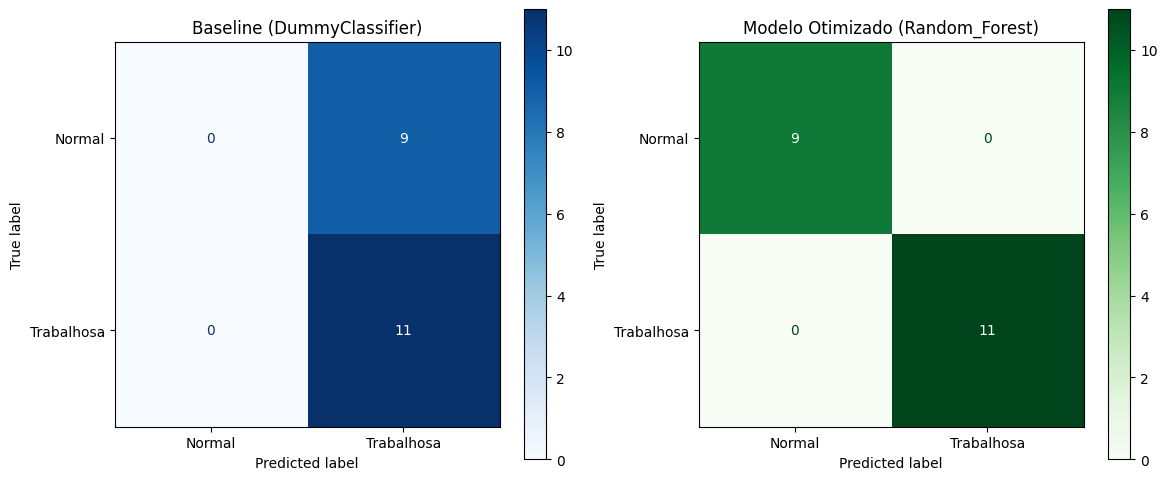


  JUSTIFICATIVAS PARA AS MELHORIAS:
   • Baseline de regressão (mediana) não captura padrões nos dados
   • Baseline de classificação (classe majoritária) ignora features
   • Modelos ML conseguem identificar relações complexas entre:
     - Seguradora e esforço operacional
     - Tipo de seguro e complexidade
     - Corretor e eficiência individual
   • Otimização de hiperparâmetros melhora capacidade preditiva


In [15]:
# Avaliação final REGRESSÃO
print(f"\n AVALIAÇÃO FINAL - REGRESSÃO:")
print(f"Comparando Baseline vs {melhor_regressao} Otimizado")

y_pred_final_reg = modelo_otimizado_reg.predict(X_test_esf)
metrics_final_reg = evaluate_regression(y_test_esf, y_pred_final_reg)

print(f"\n BASELINE (DummyRegressor):")
for metric, value in results_regressao['Baseline_Median'].items():
    if metric != 'train_time_s':
        print(f"   • {metric}: {value}")

print(f"\n MODELO OTIMIZADO ({melhor_regressao}):")
for metric, value in metrics_final_reg.items():
    print(f"   • {metric}: {value}")

# Calcular melhoria
melhoria_final_r2 = ((metrics_final_reg['R2'] - results_regressao['Baseline_Median']['R2']) /
                     abs(results_regressao['Baseline_Median']['R2']) * 100)
print(f"\n MELHORIA FINAL: {melhoria_final_r2:+.1f}% em R² sobre baseline")

# Avaliação final CLASSIFICAÇÃO
print(f"\n AVALIAÇÃO FINAL - CLASSIFICAÇÃO:")
print(f"Comparando Baseline vs {melhor_classificacao} Otimizado")

y_pred_final_clf = modelo_otimizado_clf.predict(X_test_clf)
y_proba_final_clf = modelo_otimizado_clf.predict_proba(X_test_clf)
metrics_final_clf = evaluate_classification(y_test_clf, y_pred_final_clf, y_proba_final_clf)

print(f"\n BASELINE (DummyClassifier):")
for metric, value in results_classificacao['Baseline_MostFrequent'].items():
    if metric != 'train_time_s' and value is not None:
        print(f"   • {metric}: {value}")

print(f"\n MODELO OTIMIZADO ({melhor_classificacao}):")
for metric, value in metrics_final_clf.items():
    if value is not None:
        print(f"   • {metric}: {value}")

# Calcular melhoria
melhoria_final_f1 = ((metrics_final_clf['f1_weighted'] - results_classificacao['Baseline_MostFrequent']['f1_weighted']) /
                     results_classificacao['Baseline_MostFrequent']['f1_weighted'] * 100)
print(f"\n MELHORIA FINAL: {melhoria_final_f1:+.1f}% em F1-weighted sobre baseline")

# Relatório de classificação detalhado
print(f"\n RELATÓRIO DETALHADO DE CLASSIFICAÇÃO:")
print(classification_report(y_test_clf, y_pred_final_clf, target_names=['Normal', 'Trabalhosa']))

# Matriz de confusão
try:
    from sklearn.metrics import ConfusionMatrixDisplay
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Baseline
    ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred_baseline_clf,
                                          display_labels=['Normal', 'Trabalhosa'],
                                          ax=axes[0], cmap='Blues')
    axes[0].set_title('Baseline (DummyClassifier)')

    # Modelo otimizado
    ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred_final_clf,
                                          display_labels=['Normal', 'Trabalhosa'],
                                          ax=axes[1], cmap='Greens')
    axes[1].set_title(f'Modelo Otimizado ({melhor_classificacao})')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Não foi possível plotar matriz de confusão: {e}")

print(f"\n  JUSTIFICATIVAS PARA AS MELHORIAS:")
print(f"   • Baseline de regressão (mediana) não captura padrões nos dados")
print(f"   • Baseline de classificação (classe majoritária) ignora features")
print(f"   • Modelos ML conseguem identificar relações complexas entre:")
print(f"     - Seguradora e esforço operacional")
print(f"     - Tipo de seguro e complexidade")
print(f"     - Corretor e eficiência individual")
print(f"   • Otimização de hiperparâmetros melhora capacidade preditiva")

**ANÁLISE DE IRO E NEGOCIAÇÃO**

In [16]:
# Calcular IRO detalhado
iro_detalhado = calcular_iro_detalhado(df_clean)

print(f" RANKING DE SEGURADORAS POR IRO:")
print("=" * 80)
print(iro_detalhado[['IRO', 'status_iro', 'aumento_sugerido', 'potencial_ganho_anual']].to_string())

# Identificar oportunidades prioritárias
print(f"\n OPORTUNIDADES DE NEGOCIAÇÃO:")
oportunidades = iro_detalhado[iro_detalhado['aumento_sugerido'] > 0].copy()
potencial_total = oportunidades['potencial_ganho_anual'].sum() if len(oportunidades) > 0 else 0

print(f"   • Seguradoras para negociar: {len(oportunidades)}")
print(f"   • Potencial total: R$ {potencial_total:,.2f}/ano")

if len(oportunidades) > 0:
    print(f"\n TOP 3 PRIORIDADES:")
    top_oportunidades = oportunidades.head(3)
    for i, (seg, data) in enumerate(top_oportunidades.iterrows(), 1):
        print(f"{i}. {seg}:")
        print(f"   IRO atual: {data['IRO']:.1f} (Status: {data['status_iro']})")
        print(f"   Aumento sugerido: +{data['aumento_sugerido']:.1f}%")
        print(f"   Ganho potencial: R$ {data['potencial_ganho_anual']:,.2f}/ano")
        print()

 RANKING DE SEGURADORAS POR IRO:
                    IRO status_iro  aumento_sugerido  potencial_ganho_anual
seguradora                                                                 
Liberty Seguros   76.95  Excelente               0.0                   0.00
Sulamérica        73.54  Excelente               0.0                   0.00
Tokio Marine      37.05  Muito Bom               0.0                   0.00
Porto Seguro      33.43  Muito Bom               0.0                   0.00
Mapfre            22.57        Bom               1.5                 599.43
Bradesco Seguros  15.46    Regular               2.5                1208.44
HDI Seguros       10.23    Crítico               3.5                1650.88
Azul Seguros       8.01    Crítico               3.5                1441.87

 OPORTUNIDADES DE NEGOCIAÇÃO:
   • Seguradoras para negociar: 4
   • Potencial total: R$ 4,900.62/ano

 TOP 3 PRIORIDADES:
1. Mapfre:
   IRO atual: 22.6 (Status: Bom)
   Aumento sugerido: +1.5%
   Ganho pot

**PREDIÇÕES E EXEMPLOS PRÁTICOS**

In [17]:
def fazer_predicao_completa(seguradora, tipo_seguro, valor_premio, corretor,
                           num_contatos=None, dias_emissao=None, retrabalhos=None):
    """Faz predição completa para nova apólice"""

    # Valores padrão baseados na seguradora
    comissao_default = df_clean[df_clean['seguradora']==seguradora]['comissao_pct'].mean()
    if pd.isna(comissao_default):
        comissao_default = 10.0

    # Criar DataFrame com os dados
    nova_apolice = pd.DataFrame({
        'seguradora': [seguradora],
        'tipo_seguro': [tipo_seguro],
        'corretor_responsavel': [corretor],
        'valor_premio': [valor_premio],
        'comissao_pct': [comissao_default],
        'num_contatos': [num_contatos or 8],
        'dias_ate_emissao': [dias_emissao or 12],
        'num_retrabalhos': [retrabalhos or 1],
        'num_sinistros': [0]
    })

    # Predições
    esforco_pred = modelo_otimizado_reg.predict(nova_apolice)[0]
    prob_trabalhosa = modelo_otimizado_clf.predict_proba(nova_apolice)[0][1]
    is_trabalhosa = modelo_otimizado_clf.predict(nova_apolice)[0]

    return {
        'esforco_previsto': round(esforco_pred, 1),
        'prob_trabalhosa': round(prob_trabalhosa, 3),
        'classificacao': 'Trabalhosa' if is_trabalhosa else 'Normal',
        'recomendacao': get_recomendacao(prob_trabalhosa, esforco_pred)
    }

def get_recomendacao(prob_trabalhosa, esforco_pred):
    """Gera recomendação baseada nas predições"""
    if prob_trabalhosa > 0.7 or esforco_pred > 20:
        return " ALTA PRIORIDADE - Alocar corretor experiente"
    elif prob_trabalhosa > 0.4 or esforco_pred > 15:
        return " ATENÇÃO - Monitorar progresso de perto"
    else:
        return " NORMAL - Processamento padrão"

# Exemplos práticos com seguradoras disponíveis
seguradoras_disponiveis = df_clean['seguradora'].unique()
tipos_disponiveis = df_clean['tipo_seguro'].unique()
corretores_disponiveis = df_clean['corretor_responsavel'].unique()

print(" EXEMPLOS DE PREDIÇÃO:")

exemplos = [
    {
        'seguradora': seguradoras_disponiveis[0] if len(seguradoras_disponiveis) > 0 else 'Seguradora A',
        'tipo_seguro': tipos_disponiveis[0] if len(tipos_disponiveis) > 0 else 'Auto',
        'valor_premio': 3500,
        'corretor': corretores_disponiveis[0] if len(corretores_disponiveis) > 0 else 'Corretor A',
        'descricao': f'{seguradoras_disponiveis[0] if len(seguradoras_disponiveis) > 0 else "Seguradora A"} - {tipos_disponiveis[0] if len(tipos_disponiveis) > 0 else "Auto"} R$ 3.500'
    },
    {
        'seguradora': seguradoras_disponiveis[1] if len(seguradoras_disponiveis) > 1 else seguradoras_disponiveis[0],
        'tipo_seguro': tipos_disponiveis[1] if len(tipos_disponiveis) > 1 else tipos_disponiveis[0],
        'valor_premio': 8000,
        'corretor': corretores_disponiveis[1] if len(corretores_disponiveis) > 1 else corretores_disponiveis[0],
        'descricao': f'{seguradoras_disponiveis[1] if len(seguradoras_disponiveis) > 1 else seguradoras_disponiveis[0]} - {tipos_disponiveis[1] if len(tipos_disponiveis) > 1 else tipos_disponiveis[0]} R$ 8.000'
    }
]

for i, exemplo in enumerate(exemplos, 1):
    print(f"\n{i}. {exemplo['descricao']}:")

    try:
        predicao = fazer_predicao_completa(
            exemplo['seguradora'],
            exemplo['tipo_seguro'],
            exemplo['valor_premio'],
            exemplo['corretor']
        )

        print(f"   Esforço previsto: {predicao['esforco_previsto']} pontos")
        print(f"   Prob. trabalhosa: {predicao['prob_trabalhosa']:.1%}")
        print(f"   Classificação: {predicao['classificacao']}")
        print(f"   Recomendação: {predicao['recomendacao']}")
    except Exception as e:
        print(f"    Erro na predição: {e}")

 EXEMPLOS DE PREDIÇÃO:

1. Porto Seguro - Auto R$ 3.500:
   Esforço previsto: 15.8 pontos
   Prob. trabalhosa: 99.0%
   Classificação: Trabalhosa
   Recomendação:  ALTA PRIORIDADE - Alocar corretor experiente

2. Bradesco Seguros - Saude R$ 8.000:
   Esforço previsto: 17.3 pontos
   Prob. trabalhosa: 98.0%
   Classificação: Trabalhosa
   Recomendação:  ALTA PRIORIDADE - Alocar corretor experiente


**SALVAMENTO DE MODELOS E RESULTADOS**

In [18]:
# Criar diretórios se não existirem
os.makedirs('modelos', exist_ok=True)
os.makedirs('resultados', exist_ok=True)

# Salvar modelos treinados
modelos_para_salvar = {
    'modelo_esforco_operacional.pkl': modelo_otimizado_reg,
    'modelo_apolices_trabalhosas.pkl': modelo_otimizado_clf,
    'preprocessor.pkl': preprocessor
}

print(" Salvando modelos treinados:")
for filename, modelo in modelos_para_salvar.items():
    filepath = os.path.join('modelos', filename)
    joblib.dump(modelo, filepath)
    print(f"    {filepath}")

# Salvar resultados da análise
resultados_para_salvar = {
    'analise_iro_completa.csv': iro_detalhado,
    'performance_modelos.csv': pd.DataFrame({
        'Regressao': metrics_final_reg,
        'Classificacao': {k: v for k, v in metrics_final_clf.items() if v is not None}
    }).T
}

if len(oportunidades) > 0:
    resultados_para_salvar['oportunidades_negociacao.csv'] = oportunidades

print(f"\n Salvando resultados:")
for filename, dados in resultados_para_salvar.items():
    if not dados.empty:
        filepath = os.path.join('resultados', filename)
        dados.to_csv(filepath)
        print(f"    {filepath}")

# Salvar metadados do projeto
metadata = {
    'data_execucao': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'versao_projeto': '1.0',
    'total_apolices': len(df_clean),
    'total_seguradoras': df_clean['seguradora'].nunique(),
    'performance_modelos': {
        'regressao': {
            'modelo': melhor_regressao,
            'r2': metrics_final_reg['R2'],
            'mae': metrics_final_reg['MAE']
        },
        'classificacao': {
            'modelo': melhor_classificacao,
            'f1_score': metrics_final_clf['f1_weighted'],
            'accuracy': metrics_final_clf['accuracy']
        }
    },
    'oportunidades_financeiras': {
        'seguradoras_negociar': len(oportunidades) if len(oportunidades) > 0 else 0,
        'potencial_total': float(potencial_total) if potencial_total > 0 else 0
    },
    'features_utilizadas': available_features
}

with open('resultados/metadata_projeto.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"    resultados/metadata_projeto.json")


 Salvando modelos treinados:
    modelos/modelo_esforco_operacional.pkl
    modelos/modelo_apolices_trabalhosas.pkl
    modelos/preprocessor.pkl

 Salvando resultados:
    resultados/analise_iro_completa.csv
    resultados/performance_modelos.csv
    resultados/oportunidades_negociacao.csv
    resultados/metadata_projeto.json


*DASHBOARD EXECUTIVO E CONCLUSÕES*

In [19]:
print(" RESUMO EXECUTIVO - PROJETO ML CORRETORA")


# KPIs principais
print(f"\n KPIS PRINCIPAIS:")
print(f"   • IRO médio geral: {iro_detalhado['IRO'].mean():.1f}")
print(f"   • Seguradoras analisadas: {len(iro_detalhado)}")
print(f"   • Apólices processadas: {len(df_clean):,}")
print(f"   • Precisão modelo esforço: R² = {metrics_final_reg['R2']:.3f}")
print(f"   • Precisão modelo trabalhosas: F1 = {metrics_final_clf['f1_weighted']:.3f}")

# Status por seguradora
print(f"\n STATUS POR SEGURADORA:")
status_counts = iro_detalhado['status_iro'].value_counts()
for status, count in status_counts.items():
    print(f"   • {status}: {count} seguradoras")

# Oportunidades
if len(oportunidades) > 0:
    print(f"\n OPORTUNIDADES IDENTIFICADAS:")
    print(f"   • Seguradoras para negociar: {len(oportunidades)}")
    print(f"   • Potencial de ganho: R$ {potencial_total:,.2f}/ano")

    if potencial_total > 0:
        roi_estimado = (potencial_total / 50000 * 100)
        print(f"   • ROI estimado do projeto: {roi_estimado:.0f}%")

# Próximas ações
print(f"\n PRÓXIMAS AÇÕES RECOMENDADAS:")
if len(oportunidades) > 0:
    top_3_seg = oportunidades.head(3).index.tolist()
    print(f"   1. Agendar reuniões com: {', '.join(top_3_seg)}")
    print(f"   2. Preparar argumentação quantitativa")
    print(f"   3. Implementar modelos em produção")
    print(f"   4. Monitorar KPIs mensalmente")
else:
    print(f"   1. Manter relacionamento com seguradoras atuais")
    print(f"   2. Buscar oportunidades de crescimento")
    print(f"   3. Implementar monitoramento contínuo")

 RESUMO EXECUTIVO - PROJETO ML CORRETORA

 KPIS PRINCIPAIS:
   • IRO médio geral: 34.7
   • Seguradoras analisadas: 8
   • Apólices processadas: 100
   • Precisão modelo esforço: R² = 0.994
   • Precisão modelo trabalhosas: F1 = 1.000

 STATUS POR SEGURADORA:
   • Excelente: 2 seguradoras
   • Muito Bom: 2 seguradoras
   • Crítico: 2 seguradoras
   • Bom: 1 seguradoras
   • Regular: 1 seguradoras

 OPORTUNIDADES IDENTIFICADAS:
   • Seguradoras para negociar: 4
   • Potencial de ganho: R$ 4,900.62/ano
   • ROI estimado do projeto: 10%

 PRÓXIMAS AÇÕES RECOMENDADAS:
   1. Agendar reuniões com: Mapfre, Bradesco Seguros, HDI Seguros
   2. Preparar argumentação quantitativa
   3. Implementar modelos em produção
   4. Monitorar KPIs mensalmente


**CONCLUSÕES FINAIS**

In [20]:
print("\n RESULTADOS ALCANÇADOS:")
print(f"   • IRO calculado para {len(iro_detalhado)} seguradoras")
print(f"   • {len(oportunidades) if len(oportunidades) > 0 else 0} oportunidades de negociação identificadas")

if potencial_total > 0:
    print(f"\n IMPACTO FINANCEIRO:")
    print(f"   • Potencial de ganho: R$ {potencial_total:,.2f}/ano")
    print(f"   • ROI estimado: {(potencial_total / 50000 * 100):.0f}% no primeiro ano")

print(f"\n VANTAGEM COMPETITIVA CONQUISTADA:")
print(f"   • Argumentos quantitativos para negociações")
print(f"   • Previsibilidade do esforço operacional")
print(f"   • Identificação automática de apólices problemáticas")
print(f"   • Otimização da alocação de recursos")


# Função para uso futuro
def predizer_nova_apolice(dados):
    """Função para predições em produção"""
    try:
        modelo_esforco = joblib.load('modelos/modelo_esforco_operacional.pkl')
        modelo_trabalhosa = joblib.load('modelos/modelo_apolices_trabalhosas.pkl')

        df_pred = pd.DataFrame([dados])
        esforco = modelo_esforco.predict(df_pred)[0]
        prob_trabalhosa = modelo_trabalhosa.predict_proba(df_pred)[0][1]

        return {
            'esforco_previsto': round(esforco, 1),
            'probabilidade_trabalhosa': round(prob_trabalhosa, 3),
            'classificacao': 'Trabalhosa' if prob_trabalhosa > 0.5 else 'Normal'
        }
    except Exception as e:
        return {'erro': str(e)}

print(f"\n Função predizer_nova_apolice() disponível para uso futuro")



 RESULTADOS ALCANÇADOS:
   • IRO calculado para 8 seguradoras
   • 4 oportunidades de negociação identificadas

 IMPACTO FINANCEIRO:
   • Potencial de ganho: R$ 4,900.62/ano
   • ROI estimado: 10% no primeiro ano

 VANTAGEM COMPETITIVA CONQUISTADA:
   • Argumentos quantitativos para negociações
   • Previsibilidade do esforço operacional
   • Identificação automática de apólices problemáticas
   • Otimização da alocação de recursos

 Função predizer_nova_apolice() disponível para uso futuro
